In [2]:
# global params
epoches = 400
minibatch_size = 4
learning_rate = 0.01
momentum = 0.9

bce_l, bce_u = 0.5, 0.99
pos_weight = 100.0
border_weight = 25.0

In [3]:
# from google.colab import drive
# drive.mount("/content/drive")

# !pip install google-colab-shell
# from google_colab_shell import getshell

# cd drive/MyDrive/cv/CODE/U-net
# getshell()

In [4]:
import os
import sys
import time
from PIL import Image, ImageDraw, ImageFilter

sys.path.append("../scripts")
from network.network import UNet
from network.network import DaphDataset

from train_test.train_test import test_loop
from train_test.train_test import training_loop
from train_test.train_test import WeightedNeighborhoodBCELoss

import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from torchsummary import summary
import numpy as np

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
PREFFIX  = "../../LEARNING_DATA"
FRAMES   = "frames"
HEATMAPS = "gaussians"

checkpoint_dir = os.path.join("./checkpoints_", time.strftime("%Y%m%d_%H-%M-%S"))
os.makedirs(checkpoint_dir)

train_dir   = os.path.join(PREFFIX,   "generated_data/dataset")
inputs_dir  = os.path.join(train_dir, FRAMES)
targets_dir = os.path.join(train_dir, HEATMAPS)

run_dirs = [
    (os.path.join("./train_and_test/test_data_real", FRAMES), 
     os.path.join("./train_and_test/test_data_real/nn_out_bin")),
    
    (os.path.join("./train_and_test/test_data_synt/", FRAMES), 
     os.path.join("./train_and_test/test_data_synt/nn_out_bin"))
]

In [8]:
inputs, targets = [], []
for image_name in os.listdir(inputs_dir):
    input_path = os.path.join(inputs_dir,  image_name)
    target_path = os.path.join(targets_dir, image_name)

    inputs.append (input_path )
    targets.append(target_path)

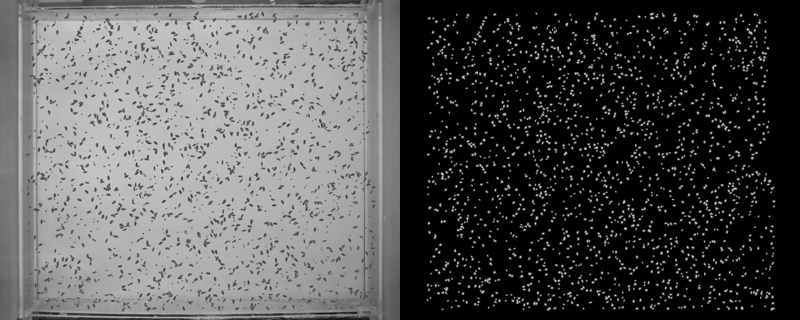

In [9]:
input_image_example = Image.open(inputs[0])
input_image_example.thumbnail((400, 400))

target_image_example = Image.open(targets[0])
target_image_example.thumbnail((400, 400))

concatination = Image.new('RGB', (input_image_example.width + target_image_example.width, input_image_example.height))
concatination.paste(input_image_example, (0, 0))
concatination.paste(target_image_example, (input_image_example.width, 0))
concatination

In [10]:
random_seed = 42
train_size = 0.9

inputs_train, inputs_valid   = train_test_split(inputs, 
                                                random_state=random_seed, 
                                                train_size=train_size, 
                                                shuffle=True)
targets_train, targets_valid = train_test_split(targets, 
                                                random_state=random_seed, 
                                                train_size=train_size, 
                                                shuffle=True)

dataset_train = DaphDataset(inputs=inputs_train, 
                            targets=targets_train, 
                            transform=None)
dataset_valid = DaphDataset(inputs=inputs_valid, 
                            targets=targets_valid, 
                            transform=None)

dataloader_train = data.DataLoader(dataset=dataset_train,
                                   batch_size=minibatch_size,
                                   shuffle=True)

dataloader_valid = data.DataLoader(dataset=dataset_valid,
                                   batch_size=minibatch_size,
                                   shuffle=False)

In [9]:
model = UNet()
model = model.to(device)
summary = summary(model, (1, 1280, 1024))

Layer (type:depth-idx)                   Output Shape              Param #
├─Encoder: 1                             []                        --
|    └─ModuleList: 2                     []                        --
|    |    └─Block: 3-1                   [-1, 8, 1280, 1024]       664
|    └─MaxPool2d: 2-1                    [-1, 8, 640, 512]         --
|    └─ModuleList: 2                     []                        --
|    |    └─Block: 3-2                   [-1, 16, 640, 512]        3,488
|    └─MaxPool2d: 2-2                    [-1, 16, 320, 256]        --
|    └─ModuleList: 2                     []                        --
|    |    └─Block: 3-3                   [-1, 32, 320, 256]        13,888
|    └─MaxPool2d: 2-3                    [-1, 32, 160, 128]        --
├─Decoder: 1                             []                        --
|    └─ModuleList: 2                     []                        --
|    |    └─ConvTranspose2d: 3-4         [-1, 16, 640, 512]        2,064
|   

In [12]:
last_chkpnt_path = training_loop(UNet, device,
                                 pos_weight, border_weight, bce_l, bce_u,
                                 learning_rate, momentum,
                                 epoches,
                                 dataloader_train, dataloader_valid,
                                 checkpoint_dir, last_chkpnt_path)

In [15]:
last_chkpnt_path = "./checkpoints_/kk/101.chkpnt"
test_loop(UNet, device, run_dirs, last_chkpnt_path=last_chkpnt_path)